In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [18]:
# Read the final results csv here
vae_classifier_results = pd.read_csv('./results/vae_with_classifier_results.csv')

In [19]:
def space_separated_str_to_list(space_separated_str):
    return [int(x) for x in space_separated_str.split()]

# Apply the function to each column
vae_classifier_results['missing_terms'] = vae_classifier_results['missing_terms'].apply(space_separated_str_to_list)
vae_classifier_results['recommended_terms'] = vae_classifier_results['recommended_terms'].apply(space_separated_str_to_list)

# Custom function to calculate precision at different levels
def precision_at_k(recommended, missing, k):
    recommended_k = recommended[:k]
    found_terms = set(recommended_k) & set(missing)
    precision = len(found_terms) / k if k > 0 else 0
    return precision

# Apply the function to create new columns
vae_classifier_results['PREC@1'] = vae_classifier_results.apply(lambda row: precision_at_k(row['recommended_terms'], row['missing_terms'], 1), axis=1)
vae_classifier_results['PREC@10'] = vae_classifier_results.apply(lambda row: precision_at_k(row['recommended_terms'], row['missing_terms'], 10), axis=1)
vae_classifier_results['PREC@20'] = vae_classifier_results.apply(lambda row: precision_at_k(row['recommended_terms'], row['missing_terms'], 20), axis=1)




In [20]:
# Group by 'country' and calculate the mean for each group
grouped_df = vae_classifier_results.groupby('country')[['PREC@1', 'PREC@10', 'PREC@20']].mean().reset_index()

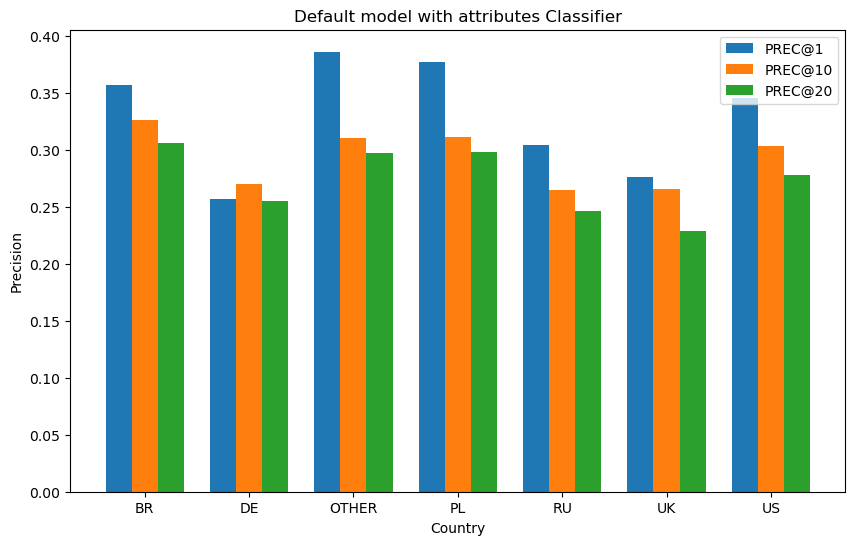

In [26]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
bar_positions_1 = range(len(grouped_df['country']))
bar_positions_2 = [pos + bar_width for pos in bar_positions_1]
bar_positions_3 = [pos + bar_width for pos in bar_positions_2]

# Plotting the bars
ax.bar(bar_positions_1, grouped_df['PREC@1'], width=bar_width, label='PREC@1')
ax.bar(bar_positions_2, grouped_df['PREC@10'], width=bar_width, label='PREC@10')
ax.bar(bar_positions_3, grouped_df['PREC@20'], width=bar_width, label='PREC@20')

# Adding labels and title
ax.set_xlabel('Country')
ax.set_ylabel('Precision')
ax.set_xticks([pos + bar_width for pos in bar_positions_1])
ax.set_xticklabels(grouped_df['country'])
ax.legend()
ax.set_title('Default model with attributes Classifier')

# Show the plot
plt.show()